## Prototype for `keyword_extraction_db.py`

Try KMeans, Agglomerative (hierarchical, ward), LDA


In [141]:
import pickle
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
import heapq
from nltk.corpus import stopwords

import functools

def compose(*functions):
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

### Pre-processing
TODO: 'we' is in stopWords, but somehow slipping through.

In [156]:
# loads abstracts from a pickle file.
# Returns a concatenation of the article title and abstract.
def load_pkl(category):
    print('Loading data')
    with open('../dumps/metha-all-math.pkl','rb') as f:
        df = pickle.load(f)
        mask = df['categories'].apply(lambda cs: category in cs)
        df = df[mask]
        print('Pre-processing text')
        df = pre_process(df)
        abstracts = df.apply(lambda row: 
            '. '.join([row['title'], row['abstract']]), axis=1)
        print('Data loaded')
        return abstracts

# do LaTeX-specific pre-processing, then removes stopwords.
# Returns processed text in lower cases.
def pre_process(df):
    remove_newline = lambda t: t.replace('\n',' ')
    process_umlaut = lambda t: re.sub("\"([auo])", r"\1", t)
    ignore_backslash = lambda t: t.replace('\\','')
    ignore_dollar = lambda t: t.replace('$','')
    pre_processor = compose(
        remove_stopwords, ignore_dollar, ignore_backslash, process_umlaut, remove_newline)
    df['abstract'] = df['abstract'].apply(pre_processor)
    df['title'] = df['title'].apply(pre_processor)
    return df

def remove_stopwords(text):
    stopWords = set(stopwords.words('english'))
    math_stopwords = ['we', 'prove', 'show', 'paper', 'study']
    for w in math_stopwords:
        stopWords.add(w)
    return ' '.join([w.lower() for w in text.split() if w.lower() not in stopWords])

In [157]:
abstracts = load_pkl("math.DS")
#abstracts.apply(print)

Loading data
Pre-processing text
Data loaded


In [125]:
abstracts.shape

(18550,)

### Clustering and keyword extraction
Clustering is done with 1-grams. Keyword extraction works well with 2- and 3-grams.

TODO: singular and plural duplicates.

When using ngram_range=(1,2) or (1,3), the lesser n-grams dominate.
1-grams tend not to be discipline-specific (e.g. "set", "measure", "compact").

In [158]:
def rank_phrases(text, n, ngram_range):
    tfidf_vect = TfidfVectorizer(ngram_range=ngram_range)
    text_vect = tfidf_vect.fit_transform(text)
    text_vect = np.asarray(text_vect.sum(axis=0)).ravel()
    tfidf_dict = dict()
    idf = tfidf_vect.idf_
    for k, v in tfidf_vect.vocabulary_.items():
        tfidf_dict[k] = text_vect[v]
    return heapq.nlargest(n, tfidf_dict, key=tfidf_dict.get)

# clustering is done with 1-grams
def cluster_docs(abstracts, K):
    tfidf_vect = TfidfVectorizer()
    abs_tfidf = tfidf_vect.fit_transform(abstracts)
    #print('Running kmeans.')
    kmeans = MiniBatchKMeans(n_clusters=K, batch_size=1000, reassignment_ratio=0.1).fit(abs_tfidf)
    #print('Kmeans finished.')
    cluster_idx = kmeans.predict(abs_tfidf)
    return cluster_idx

# abstracts: pandas Series, shape=(n,).
def extract_keywords(abstracts, K=200, topN=5, ngram_range=(2,3)):
    cluster_idx = cluster_docs(abstracts, K)
    abs_clusters = pd.DataFrame({
        'cluster': cluster_idx,
        'text': abstracts
    })
    
    keywords = []
    for j in range(K):
        # get the j^th cluster
        c = abs_clusters[abs_clusters['cluster']==j]
        
        for phrase in rank_phrases(c['text'], topN, ngram_range):
            keywords.append(phrase)

    return keywords

In [159]:
kwds = extract_keywords(abstracts, K=50, topN=10)
kwds = set(kwds)

In [160]:
print(len(kwds))
kwds

407


{'abelian differentials',
 'abelian groups',
 'absolutely continuous',
 'action gamma',
 'action kinetics',
 'affine sets',
 'algebras associated',
 'almost periodic',
 'alpha alpha',
 'alpha beta',
 'amenable group',
 'amenable groups',
 'angular momentum',
 'anosov diffeomorphisms',
 'anosov flow',
 'anosov flows',
 'area preserving',
 'asymptotic stability',
 'asymptotically stable',
 'automorphism group',
 'automorphism groups',
 'average shadowing',
 'average shadowing property',
 'basic reproduction',
 'basic reproduction number',
 'beta beta',
 'beta expansion',
 'beta expansions',
 'beta function',
 'beta transformation',
 'billiard map',
 'billiard table',
 'billiard tables',
 'billiard trajectories',
 'body problem',
 'boundary conditions',
 'cellular automata',
 'central configurations',
 'chemical reaction',
 'chemical reaction networks',
 'chimera states',
 'circle maps',
 'class skew',
 'closed currents',
 'closed geodesics',
 'codimension one',
 'compact metric',
 'compa

### KMeans parameter tuning.
The inertia of clusters goes down as n_clusters increases---where to stop?
n_clusters -> large = keywords more specific to sub-disciplines?

The number of articles in math.DS is 18550. So,

| n_cluster | E(cluster_size) (rounded)|
|----|----|
| 10 | 1855 |
| 50 | 371 |
| 100 | 186 |
| 200 | 93 |
| 400 | 46 |
| 600 | 30 |

Do n_clusters = 50, 100, 200, and 400, which corresponds to roughly E(cluster_size) = 400, 200, 100, 50.

In [133]:
18550/600

30.916666666666668

In [105]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [95]:
def kmeans_tuner(abstracts, parameters):
    tfidf_vect = TfidfVectorizer()
    abs_tfidf = tfidf_vect.fit_transform(abstracts)
    inertia = []
    for k in parameters:
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, reassignment_ratio=0).fit(abs_tfidf)
        inertia.append(kmeans.inertia_)  
    return list(zip(parameters, inertia))

In [112]:
parameters = [50*i for i in range(1,20)]
inertia = kmeans_tuner(abstracts, parameters)

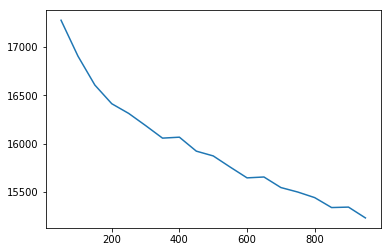

In [113]:
unzipped = list(zip(*inertia))
plt.plot(unzipped[0], unzipped[1])